In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, expr, lit, min, max, mean,udf,regexp_replace
from pyspark.sql.types import StringType
from unidecode import unidecode
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pdimport 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np


In [2]:
spark = SparkSession.builder\
    .config("spark.jars", "duckdb.jar") \
    .getOrCreate()

24/04/25 17:45:11 WARN Utils: Your hostname, Ruths-MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.143 instead (on interface en0)
24/04/25 17:45:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/04/25 17:45:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
DF = spark.read \
  .format("jdbc") \
  .option("url", "jdbc:duckdb:exploited_zone/freshdata_exploited1.db") \
  .option("driver", "org.duckdb.DuckDBDriver") \
  .option("query", "SELECT * FROM nova_base") \
  .load()
DF.show()

+----+-------------------+------------------+------------------+------------------+
|Year|           District|  Year_Price_month|     Year_Price_m2|   District_Income|
+----+-------------------+------------------+------------------+------------------+
|2015|     Horta-Guinardo| 595.0114634146341| 9.773170731707317|32367.845528455284|
|2015|         Nou Barris|501.61857142857133| 8.373571428571429|27483.162393162394|
|2016|     Sants-Montjuic| 662.4172413793102|11.238620689655173| 31840.05982905983|
|2015|     Sants-Montjuic| 611.3019999999999|10.202333333333334|31367.478632478633|
|2019|     Sants-Montjuic| 823.6586206896551|12.972413793103447| 35258.96581196581|
|2020|         Nou Barris| 678.4699999999998|11.259999999999998|           30406.0|
|2016|             Gracia| 756.1959999999999|12.372000000000002| 37910.24137931035|
|2015|Sarria-Sant Gervasi|1083.3508333333332|13.027083333333332|60116.102040816324|
|2021|     Sants-Montjuic|  798.932142857143|12.678571428571427| 36198.78632

In [4]:
db=DF.toPandas()
db

,Year,District,Year_Price_month,Year_Price_m2,District_Income
0,2015,Horta-Guinardo,595.011463,9.773171,32367.845528
1,2015,Nou Barris,501.618571,8.373571,27483.162393
2,2016,Sants-Montjuic,662.417241,11.238621,31840.059829
3,2015,Sants-Montjuic,611.302000,10.202333,31367.478632
4,2019,Sants-Montjuic,823.658621,12.972414,35258.965812
...,...,...,...,...,...
65,2019,Ciutat Vella,960.343750,15.293750,28441.740741
66,2018,Nou Barris,648.947561,10.827561,29404.957265
67,2018,Sarria-Sant Gervasi,1254.222500,15.192083,67783.346939
68,2016,Horta-Guinardo,649.610000,10.670250,32968.967480


In [5]:

def encontrar_numero_clusters(datos, max_clusters=10):
    # Almacenar valores de inercia y silueta para cada número de clusters
    inercia = []
    silhouette_scores = []
    
    # Probar diferentes números de clusters
    for n_clusters in range(2, max_clusters + 1):
        # Inicializar y ajustar el modelo KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(datos)
        
        # Calcular la inercia (suma de las distancias cuadradas de cada punto al centroide más cercano)
        inercia.append(kmeans.inertia_)
        
        # Calcular el coeficiente de la silueta
        if len(set(kmeans.labels_)) > 1:  # Asegurarse de que haya al menos 2 clusters
            silhouette_scores.append(silhouette_score(datos, kmeans.labels_))
        else:
            silhouette_scores.append(np.nan)
    
    # Encontrar el codo en la curva de inercia (método del codo)
    deltas = np.diff(inercia, 2)  # Segunda derivada de la curva de inercia
    optimal_clusters = np.argmin(deltas) + 2  # El número de clusters donde se produce el codo
    
    return optimal_clusters


In [6]:
# Selecciona las características relevantes para el clustering
X = db[['Year_Price_month', 'Year_Price_m2', 'District_Income']]

optimal_clusters = encontrar_numero_clusters(X)

# Aplica KMeans
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)  # Cambia el número de clústeres según desees
kmeans.fit(X)

# Añade las etiquetas de los clústeres al DataFrame original
db['Cluster'] = kmeans.labels_

# Visualiza los resultados
db

/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ruthparajo/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The defa

,Year,District,Year_Price_month,Year_Price_m2,District_Income,Cluster
0,2015,Horta-Guinardo,595.011463,9.773171,32367.845528,0
1,2015,Nou Barris,501.618571,8.373571,27483.162393,4
2,2016,Sants-Montjuic,662.417241,11.238621,31840.059829,0
3,2015,Sants-Montjuic,611.302000,10.202333,31367.478632,0
4,2019,Sants-Montjuic,823.658621,12.972414,35258.965812,3
...,...,...,...,...,...,...
65,2019,Ciutat Vella,960.343750,15.293750,28441.740741,4
66,2018,Nou Barris,648.947561,10.827561,29404.957265,4
67,2018,Sarria-Sant Gervasi,1254.222500,15.192083,67783.346939,6
68,2016,Horta-Guinardo,649.610000,10.670250,32968.967480,0


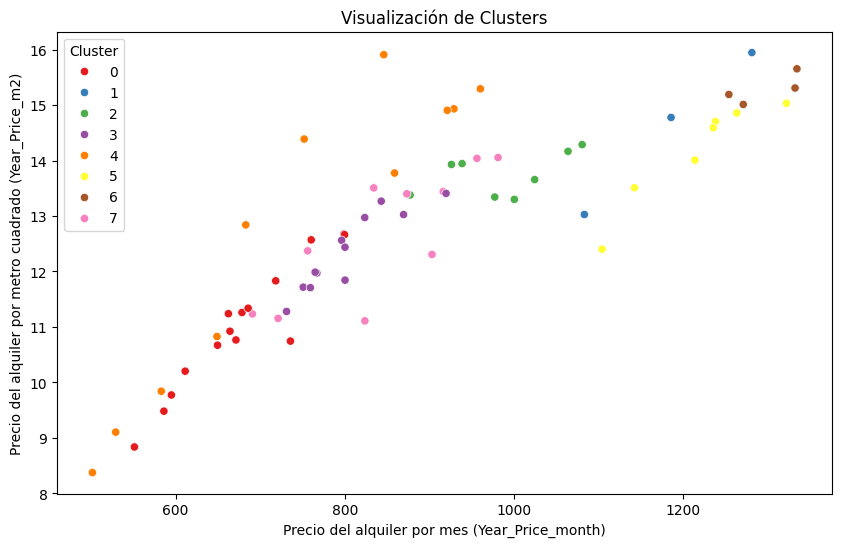

In [7]:
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar los puntos de datos agrupados por clusters
sns.scatterplot(x='Year_Price_month', y='Year_Price_m2', hue='Cluster', data=db, palette='Set1', ax=ax)

# Agregar etiquetas y título
plt.xlabel('Precio del alquiler por mes (Year_Price_month)')
plt.ylabel('Precio del alquiler por metro cuadrado (Year_Price_m2)')
plt.title('Visualización de Clusters')

# Mostrar la leyenda
plt.legend(title='Cluster')

# Mostrar el gráfico
plt.show()


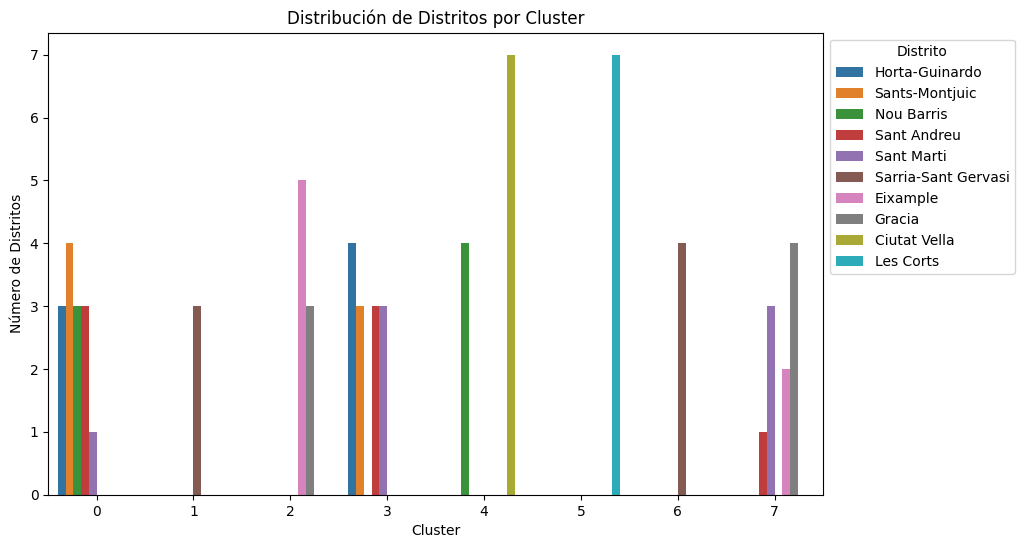

In [11]:
# Muestra un plot de los barrios que aparecen y su frecuencia para cada cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=db, x='Cluster', hue='District')
plt.title('Distribución de Distritos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Distritos')
plt.legend(title='Distrito', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=db, x='Cluster', hue='District')
plt.title('Distribución de Distritos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Distritos')
plt.legend(title='Distrito', bbox_to_anchor=(1, 1))
plt.show()

In [12]:
db

,Year,District,Year_Price_month,Year_Price_m2,District_Income,Cluster
0,2015,Horta-Guinardo,595.011463,9.773171,32367.845528,0
1,2015,Nou Barris,501.618571,8.373571,27483.162393,4
2,2016,Sants-Montjuic,662.417241,11.238621,31840.059829,0
3,2015,Sants-Montjuic,611.302000,10.202333,31367.478632,0
4,2019,Sants-Montjuic,823.658621,12.972414,35258.965812,3
...,...,...,...,...,...,...
65,2019,Ciutat Vella,960.343750,15.293750,28441.740741,4
66,2018,Nou Barris,648.947561,10.827561,29404.957265,4
67,2018,Sarria-Sant Gervasi,1254.222500,15.192083,67783.346939,6
68,2016,Horta-Guinardo,649.610000,10.670250,32968.967480,0


24/04/25 17:27:15 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 373776 ms exceeds timeout 120000 ms
24/04/25 17:27:15 WARN SparkContext: Killing executors is not supported by current scheduler.
24/04/25 17:27:19 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Supongamos que tienes un DataFrame llamado 'data' con las características (variables predictoras) 'feature1', 'feature2', y 'feature3', 
# y la variable objetivo 'District'

# Dividir los datos en conjuntos de entrenamiento y prueba
X = db[['Year_Price_month', 'Year_Price_m2', 'District_Income']]
y = db['District']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo KNN
k = 5  # número de vecinos
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred = knn_model.predict(X_test_scaled)

# Evaluar el rendimiento del modelo
print("Accuracy del modelo KNN:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy del modelo KNN: 0.7857142857142857

Reporte de clasificación:
                      precision    recall  f1-score   support

           Eixample       1.00      0.50      0.67         2
             Gracia       1.00      1.00      1.00         1
     Horta-Guinardo       1.00      0.67      0.80         3
          Les Corts       1.00      1.00      1.00         1
         Nou Barris       1.00      1.00      1.00         2
        Sant Andreu       0.33      1.00      0.50         1
         Sant Marti       0.00      0.00      0.00         0
     Sants-Montjuic       1.00      0.67      0.80         3
Sarria-Sant Gervasi       1.00      1.00      1.00         1

           accuracy                           0.79        14
          macro avg       0.81      0.76      0.75        14
       weighted avg       0.95      0.79      0.83        14



24/04/25 17:33:49 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/25 17:33:59 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE